In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
MAX_ROUNDS = 400 
OPTIMIZE_ROUNDS = False
LEARNING_RATE = 0.07
EARLY_STOPPING_RATE=50

In [3]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from numba import jit
import time
import gc

Module Numba

모델의 성능 향상에 관여하는 모듈

<공식문서>

"Numba makes Python code fast.
Numba is an open source JIT compiler that translates a subset of Python and NumPy code into fast machine code."

-> 넘파이 코드를 빠르게 실행시켜주는 JIT 컴파일러 

In [4]:
# 지니 계수 계산 코드

@jit
def eval_gini(y_true, y_prob) :
  y_true = np.asarray(y_true) # numba가 이해할 수 있는 형식으로 변환
  y_true = y_true[np.argsort(y_prob)]
  ntrue= 0
  gini =0 
  delta = 0
  n=len(y_true)
  for i in range(n-1,-1,-1) :
    y_i = y_true[i]
    ntrue += y_i
    gini += y_i * delta
    delta += 1-y_i
  gini = 1-2*gini/(ntrue*(n-ntrue))
  return gini

## 지니계수 계산 공식
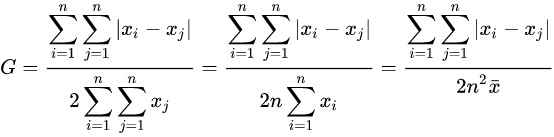

## 지니계수 계산 코드


```
def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area
```




아래 코드에서 분류에 사용한 XGBClassifier모델은 평가 지표로 rmse와 같은 값을 사용 -> 즉 오류의 최솟값을 찾음

이 대회의 평가 지표인 지니 계수 : 0.5에 가까울수록(값이 클수록) 좋은 값이기 때문에 -를 붙여주는 함수를 생성.

In [5]:
def gini_xgb(preds, dtrain) :
  labels = dtrain.get_label()
  gini_score = -eval_gini(labels,preds)
  return [('gini',gini_score)]

def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None,   
                  val_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
  
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
   
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
   
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    
    prior = target.mean()

    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)

    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)

    ft_trn_series.index = trn_series.index
    ft_val_series = pd.merge(
        val_series.to_frame(val_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=val_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)

    ft_val_series.index = val_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)

    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_val_series, noise_level), add_noise(ft_tst_series, noise_level)

In [6]:
train = pd.read_csv('/content/drive/MyDrive/KUBIG/KaggleStudy/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/KUBIG/KaggleStudy/data/test.csv')

In [7]:
train_features = [
    "ps_car_13",  #            : 1571.65 / shadow  609.23
	"ps_reg_03",  #            : 1408.42 / shadow  511.15
	"ps_ind_05_cat",  #        : 1387.87 / shadow   84.72
	"ps_ind_03",  #            : 1219.47 / shadow  230.55
	"ps_ind_15",  #            :  922.18 / shadow  242.00
	"ps_reg_02",  #            :  920.65 / shadow  267.50
	"ps_car_14",  #            :  798.48 / shadow  549.58
	"ps_car_12",  #            :  731.93 / shadow  293.62
	"ps_car_01_cat",  #        :  698.07 / shadow  178.72
	"ps_car_07_cat",  #        :  694.53 / shadow   36.35
	"ps_ind_17_bin",  #        :  620.77 / shadow   23.15
	"ps_car_03_cat",  #        :  611.73 / shadow   50.67
	"ps_reg_01",  #            :  598.60 / shadow  178.57
	"ps_car_15",  #            :  593.35 / shadow  226.43
	"ps_ind_01",  #            :  547.32 / shadow  154.58
	"ps_ind_16_bin",  #        :  475.37 / shadow   34.17
	"ps_ind_07_bin",  #        :  435.28 / shadow   28.92
	"ps_car_06_cat",  #        :  398.02 / shadow  212.43
	"ps_car_04_cat",  #        :  376.87 / shadow   76.98
	"ps_ind_06_bin",  #        :  370.97 / shadow   36.13
	"ps_car_09_cat",  #        :  214.12 / shadow   81.38
	"ps_car_02_cat",  #        :  203.03 / shadow   26.67
	"ps_ind_02_cat",  #        :  189.47 / shadow   65.68
	"ps_car_11",  #            :  173.28 / shadow   76.45
	"ps_car_05_cat",  #        :  172.75 / shadow   62.92
	"ps_calc_09",  #           :  169.13 / shadow  129.72
	"ps_calc_05",  #           :  148.83 / shadow  120.68
	"ps_ind_08_bin",  #        :  140.73 / shadow   27.63
	"ps_car_08_cat",  #        :  120.87 / shadow   28.82
	"ps_ind_09_bin",  #        :  113.92 / shadow   27.05
	"ps_ind_04_cat",  #        :  107.27 / shadow   37.43
	"ps_ind_18_bin",  #        :   77.42 / shadow   25.97
	"ps_ind_12_bin",  #        :   39.67 / shadow   15.52
	"ps_ind_14",  #            :   37.37 / shadow   16.65
]
# add combinations
combs = [
    ('ps_reg_01', 'ps_car_02_cat'),  
    ('ps_reg_01', 'ps_car_04_cat'),
]

라벨 인코딩

https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=wideeyed&logNo=221592651246

In [8]:
id_train = train['id'].values
id_test = test['id'].values
y=train['target']

start = time.time()
for n_c, (f1,f2) in enumerate(combs) : # enumerate : 인덱스 번호와 컬렉션 원소를 tuple 형태로 반환
  name1 = f1 + "_plus_" + f2
  print('current feature %60s %4d in %5.1f'
        % (name1, n_c +1, (time.time()-start)/60), end='')
  print('\r'*75, end = '')
  train[name1] = train[f1].apply(lambda x : str(x)) + "_" + train[f2].apply(lambda x : str(x))
  test[name1] = test[f1].apply(lambda x : str(x)) + "_" + test[f2].apply(lambda x : str(x))

  lbl = LabelEncoder()
  lbl.fit(list(train[name1].values) + list(test[name1].values)) 
  # test셋에서만 등장한 라벨이 존재할 수 있기 때문에 train, test 모두에서 등장한 라벨들에 대해 fitting해줘야 함
  train[name1] = lbl.transform(list(train[name1].values))
  test[name1] = lbl.transform(list(test[name1].values))

  train_features.append(name1)

X = train[train_features]
test = test[train_features]

f_cats = [f for f in X.columns if "_cat" in f]

In [9]:
y_valid_pred = 0*y
y_test_pred = 0

In [10]:
K = 5
kf = KFold(n_splits= K, random_state=1, shuffle = True)
np.random.seed(0)

In [11]:
model = XGBClassifier(
    n_estimators = MAX_ROUNDS, 
    max_depth = 4,
    objective = 'binary:logistic', # target : binary 값이므로 학습 목표를 명확히 지정
    learning_rate = LEARNING_RATE,
    subsample = .8, # 데이터의 0.8을 데이터 생성에 사용
    min_child_weight = 6,
    colsample_bytree = .8, # 각 트리에 얼마의 column을 이용해서 구성할 것인지
    scale_pos_weight = 1.6,
    gamma = 10,
    reg_alpha=10,
    reg_lambda=1.3
)

In [12]:
for i, (train_index, test_index) in enumerate(kf.split(train)) :

  y_train,y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
  X_train,X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index, :].copy()
  X_test = test.copy()
  print("\nFold", i )

  for f in f_cats :
    X_train[f + "_avg"], X_valid[f+'_avg'], X_test[f+"_avg"] = target_encode(
    trn_series= X_train[f],
    val_series=X_valid[f],
    tst_series=X_test[f],
    target=y_train,
    min_samples_leaf=200,
    smoothing=10,
    noise_level=0)
  if OPTIMIZE_ROUNDS : 
    eval_set = [(X_valid,y_valid)]
    fit_model = model.fit(X_train,y_train, eval_set=eval_set,
                          eval_metric=gini_xgb,
                          early_stopping_rounds = EARLY_STOPPING_ROUNDS,
                          verbose=False)
    print("Best N trees = ", model.best_ntree_limit)
    print("Best gini = ",model.best_score)
  else :
    fit_model = model.fit(X_train,y_train)

  pred = fit_model.predict_proba(X_valid)[:,1] # 1로 분류될 확률에 대한 열을 가져옴
  print("Gini = ", eval_gini(y_valid,pred))
  y_valid_pred.iloc[test_index] = pred

  y_test_pred += fit_model.predict_proba(X_test)[:,1] 

  del X_test, X_train, X_valid, y_train

print("\nGini for full training set : ")
eval_gini(y,y_valid_pred)


Fold 0


<ipython-input-4-4c8cec391835>:3: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "eval_gini" failed type inference due to: non-precise type pyobject
During: typing of argument at <ipython-input-4-4c8cec391835> (5)

File "<ipython-input-4-4c8cec391835>", line 5:
def eval_gini(y_true, y_prob) :
  y_true = np.asarray(y_true) # numba가 이해할 수 있는 형식으로 변환
  ^

  @jit
<ipython-input-4-4c8cec391835>:3: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "eval_gini" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-4-4c8cec391835>", line 11:
def eval_gini(y_true, y_prob) :
    <source elided>
  n=len(y_true)
  for i in range(n-1,-1,-1) :
  ^

  @jit
/usr/local/lib/python3.7/dist-packages/numba/core/object_mode_passes.py:178: NumbaWarning: Function "eval_gini" was compiled in object mode without forceobj=True, but has li

Gini =  0.28567263218972716

Fold 1
Gini =  0.2819863577751057

Fold 2
Gini =  0.2744086703325922

Fold 3
Gini =  0.3004816619590289

Fold 4
Gini =  0.2826294177005454

Gini for full training set : 


<ipython-input-4-4c8cec391835>:3: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "eval_gini" failed type inference due to: non-precise type pyobject
During: typing of argument at <ipython-input-4-4c8cec391835> (5)

File "<ipython-input-4-4c8cec391835>", line 5:
def eval_gini(y_true, y_prob) :
  y_true = np.asarray(y_true) # numba가 이해할 수 있는 형식으로 변환
  ^

  @jit
<ipython-input-4-4c8cec391835>:3: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "eval_gini" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-4-4c8cec391835>", line 11:
def eval_gini(y_true, y_prob) :
    <source elided>
  n=len(y_true)
  for i in range(n-1,-1,-1) :
  ^

  @jit
/usr/local/lib/python3.7/dist-packages/numba/core/object_mode_passes.py:178: NumbaWarning: Function "eval_gini" was compiled in object mode without forceobj=True, but has li

0.28481022678880197

Another Example

https://www.kaggle.com/rshally/porto-xgb-lgb-kfold-lb-0-282

In [13]:
val = pd.DataFrame()
val['id'] = id_train
val['target']= y_valid_pred.values
val.to_csv('/content/drive/MyDrive/KUBIG/KaggleStudy/Porto_Seguro\'s_Safe_Driver_Prediction/xgb_valid.csv', float_format="%.6f", index=False)  

In [14]:
sub=pd.DataFrame()
sub['id'] = id_test
sub['target'] = y_test_pred
sub.to_csv('/content/drive/MyDrive/KUBIG/KaggleStudy/Porto_Seguro\'s_Safe_Driver_Prediction/xgb_submit.csv', float_format="%.6f",index=False)

## Example

In [15]:
name1 = 'ps_reg_01' + "_plus_" + 'ps_car_02_cat'
name1

'ps_reg_01_plus_ps_car_02_cat'

In [16]:
train[name1] = train['ps_reg_01'].apply(lambda x : str(x)) + "_" + train['ps_car_02_cat'].apply(lambda x : str(x))
test[name1] = test['ps_reg_01'].apply(lambda x : str(x)) + "_" + test['ps_car_02_cat'].apply(lambda x : str(x))
list(train[name1].values) + list(test[name1].values)

['0.7_1',
 '0.8_1',
 '0.0_1',
 '0.9_1',
 '0.7_1',
 '0.9_0',
 '0.6_1',
 '0.7_1',
 '0.9_1',
 '0.9_0',
 '0.5_1',
 '0.9_0',
 '0.5_1',
 '0.7_1',
 '0.8_1',
 '0.4_1',
 '0.6_1',
 '0.9_1',
 '0.3_1',
 '0.9_1',
 '0.4_1',
 '0.7_1',
 '0.6_0',
 '0.2_1',
 '0.4_1',
 '0.1_1',
 '0.6_1',
 '0.9_1',
 '0.2_0',
 '0.9_0',
 '0.7_1',
 '0.6_1',
 '0.7_1',
 '0.5_1',
 '0.9_1',
 '0.9_1',
 '0.0_1',
 '0.9_1',
 '0.9_1',
 '0.3_1',
 '0.9_0',
 '0.8_0',
 '0.5_1',
 '0.7_1',
 '0.6_1',
 '0.3_1',
 '0.4_1',
 '0.1_1',
 '0.6_1',
 '0.9_1',
 '0.9_0',
 '0.8_1',
 '0.9_1',
 '0.8_1',
 '0.6_1',
 '0.3_1',
 '0.4_1',
 '0.9_0',
 '0.6_1',
 '0.5_1',
 '0.5_1',
 '0.9_1',
 '0.9_1',
 '0.6_1',
 '0.7_1',
 '0.3_1',
 '0.2_1',
 '0.8_1',
 '0.9_0',
 '0.7_1',
 '0.1_1',
 '0.7_1',
 '0.4_1',
 '0.1_1',
 '0.4_1',
 '0.7_1',
 '0.9_1',
 '0.9_1',
 '0.9_0',
 '0.9_1',
 '0.1_0',
 '0.6_1',
 '0.0_1',
 '0.4_1',
 '0.8_1',
 '0.9_1',
 '0.9_1',
 '0.4_1',
 '0.8_1',
 '0.9_1',
 '0.9_1',
 '0.5_1',
 '0.1_1',
 '0.9_1',
 '0.6_1',
 '0.9_0',
 '0.9_1',
 '0.6_1',
 '0.8_1',
 '0.9_1',


In [17]:
X = train[train_features]
test = test[train_features]

f_cats = [f for f in X.columns if "_cat" in f]